In [1]:
from IPython import display

# kill error when executing argparse in IPython console
import sys; sys.argv=['']; del sys

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from torchsampler import ImbalancedDatasetSampler

In [2]:
def collate_fn(batch=128):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch) 

In [3]:
import argparse
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm

# parse arguments
parser = argparse.ArgumentParser(description='Imbalanced Dataset Example')
parser.add_argument('--data', metavar='DIR', default='/projects/p31410/Gaze_Pytorch/',help='path to dataset')
parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet18')
parser.add_argument('--epochs', default=10, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch-size', default=256, type=int,
                    metavar='N', help='mini-batch size (default: 256)')
parser.add_argument('--lr', '--learning-rate', default=0.01, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
args = parser.parse_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Data loading code
traindir = os.path.join(args.data, 'Train')
valdir = os.path.join(args.data, 'Test')
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_dataset = torchvision.datasets.ImageFolder(
    traindir,
    torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        normalize,
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, 
    shuffle=True, sampler=None,  collate_fn=collate_fn, **kwargs)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(
        valdir, torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            normalize,
    ])), batch_size=args.batch_size, 
    shuffle=False, collate_fn=collate_fn, **kwargs)


In [4]:
import time 

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def process(train_loader, test_loader):
    
    model = torchvision.models.__dict__[args.arch]()
    if args.arch.startswith('alexnet') or args.arch.startswith('vgg'):
        model.features = torch.nn.DataParallel(model.features)
        model.cuda()
    else:
        model = models.resnet18(pretrained=True)

    # define loss function (criterion) and optimizer
    criterion = torch.nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

    
    # train & test process
    def train(train_loader):
        since = time.time()
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):            
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            print('\rTraining %d / %d' % (batch_idx + 1, len(train_loader)), end='', flush=True)     
        time_elapsed = time.time() - since
        print(' Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
       

        
    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100. * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx
    
    test_accs, confusion_mtxes = [], []    
    for epoch in range(1, args.epochs + 1):
        adjust_learning_rate(optimizer, epoch)
        train(train_loader)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs), end='', flush=True)
        
    vis(test_accs, confusion_mtxes, classe_labels)
    
    torch.save(model, '/home/tsb7592/Downloads/model_crop10.pth')
    return model

Dataset: 44739 training samples & 13663 testing samples

Distribution of classes in dataset:


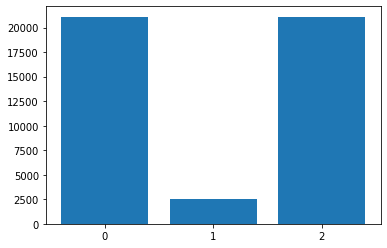

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
        
from torchvision import datasets, transforms, models
import seaborn as sns

print('Dataset: %d training samples & %d testing samples\n' % (
    len(train_loader.dataset), len(test_loader.dataset)))
 
print('Distribution of classes in dataset:')
fig, ax = plt.subplots()
labels = [label for _, label in train_loader.dataset.imgs]
classe_labels, counts = np.unique(labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    target_names= ('Away','Left','Right')
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=target_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Greens")
    plt.show()

Training 175 / 175 Training complete in 32m 23s
Training 175 / 175.78% Training complete in 25m 54s
Training 175 / 175.78% Training complete in 22m 48s
Training 175 / 175.96% Training complete in 14m 16s
Training 175 / 175.96% Training complete in 17m 33s
Training 175 / 175.96% Training complete in 18m 5s
Training 175 / 175.96% Training complete in 114m 41s
Training 175 / 175.60% Training complete in 262m 4s
Training 175 / 175.60% Training complete in 241m 49s
Training 175 / 175.60% Training complete in 247m 56s
Best test acc = 82.60%

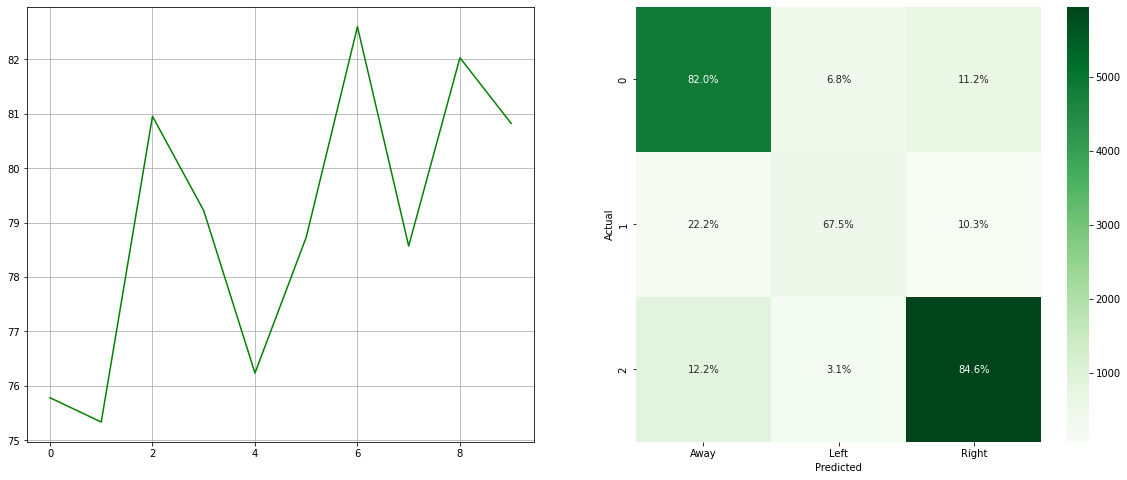

In [6]:
new10 = process(torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, 
    sampler=ImbalancedDatasetSampler(train_dataset),
    **kwargs), test_loader)

Training 175 / 175Training complete in 17m 51s
Training 175 / 175.06%Training complete in 17m 34s
Training 175 / 175.19%Training complete in 17m 34s
Training 175 / 175.19%Training complete in 29m 30s
Training 175 / 175.31%Training complete in 35m 59s
Best test acc = 82.31%

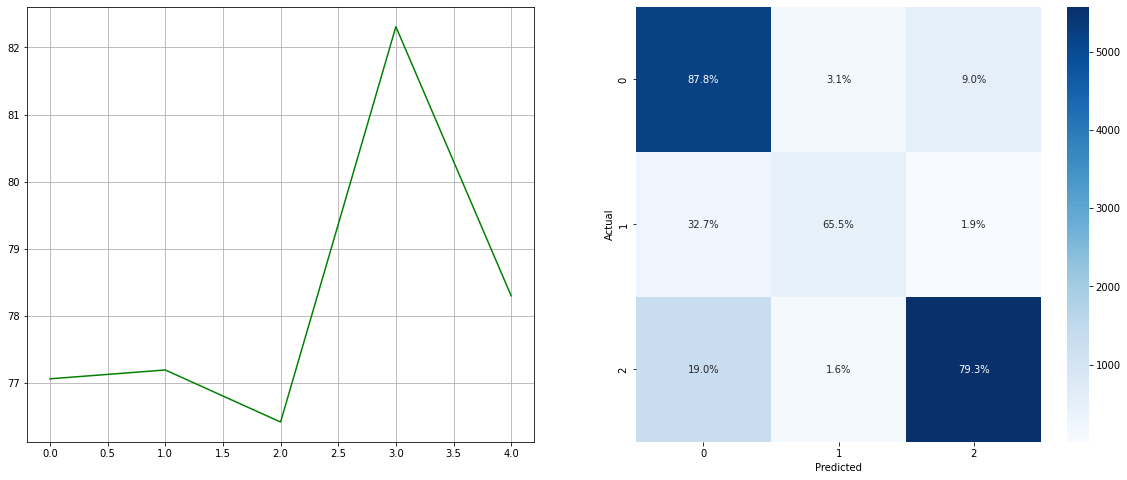

In [10]:
new= process(torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, 
    sampler=ImbalancedDatasetSampler(train_dataset),
    **kwargs), test_loader)